# VAD

## Abstract

## Introduction

## Method

### Measure of performance

### Dataset

All audio files were associated with a label file of the same name.
1. Volume
    1. 1914 files
       1. 957 .wav audio
       2. 957 .json abels

### Technical setup

In [261]:
# Move to project path
import os
os.chdir(context.project_path)

# import dependencies
import os
import scipy
import glob
import time
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# run kedro pipelines
from kedro.io import DataCatalog, MemoryDataSet
from kedro.runner import SequentialRunner
from vad.pipelines.data_eng import pipeline as data_eng
from vad.pipelines.inference import pipeline as inference
from vad.pipelines.evaluate import pipeline as evaluate
from kedro.pipeline import Pipeline
import mlflow
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset

# ignore warnings for esthetics
import warnings
warnings.filterwarnings('ignore')

In [262]:
# parameters
VERBOSE = True

### Model implementation

#### System description

##### Training pipeline

We show below our training pipeline, plotted with `kedro-viz` api.

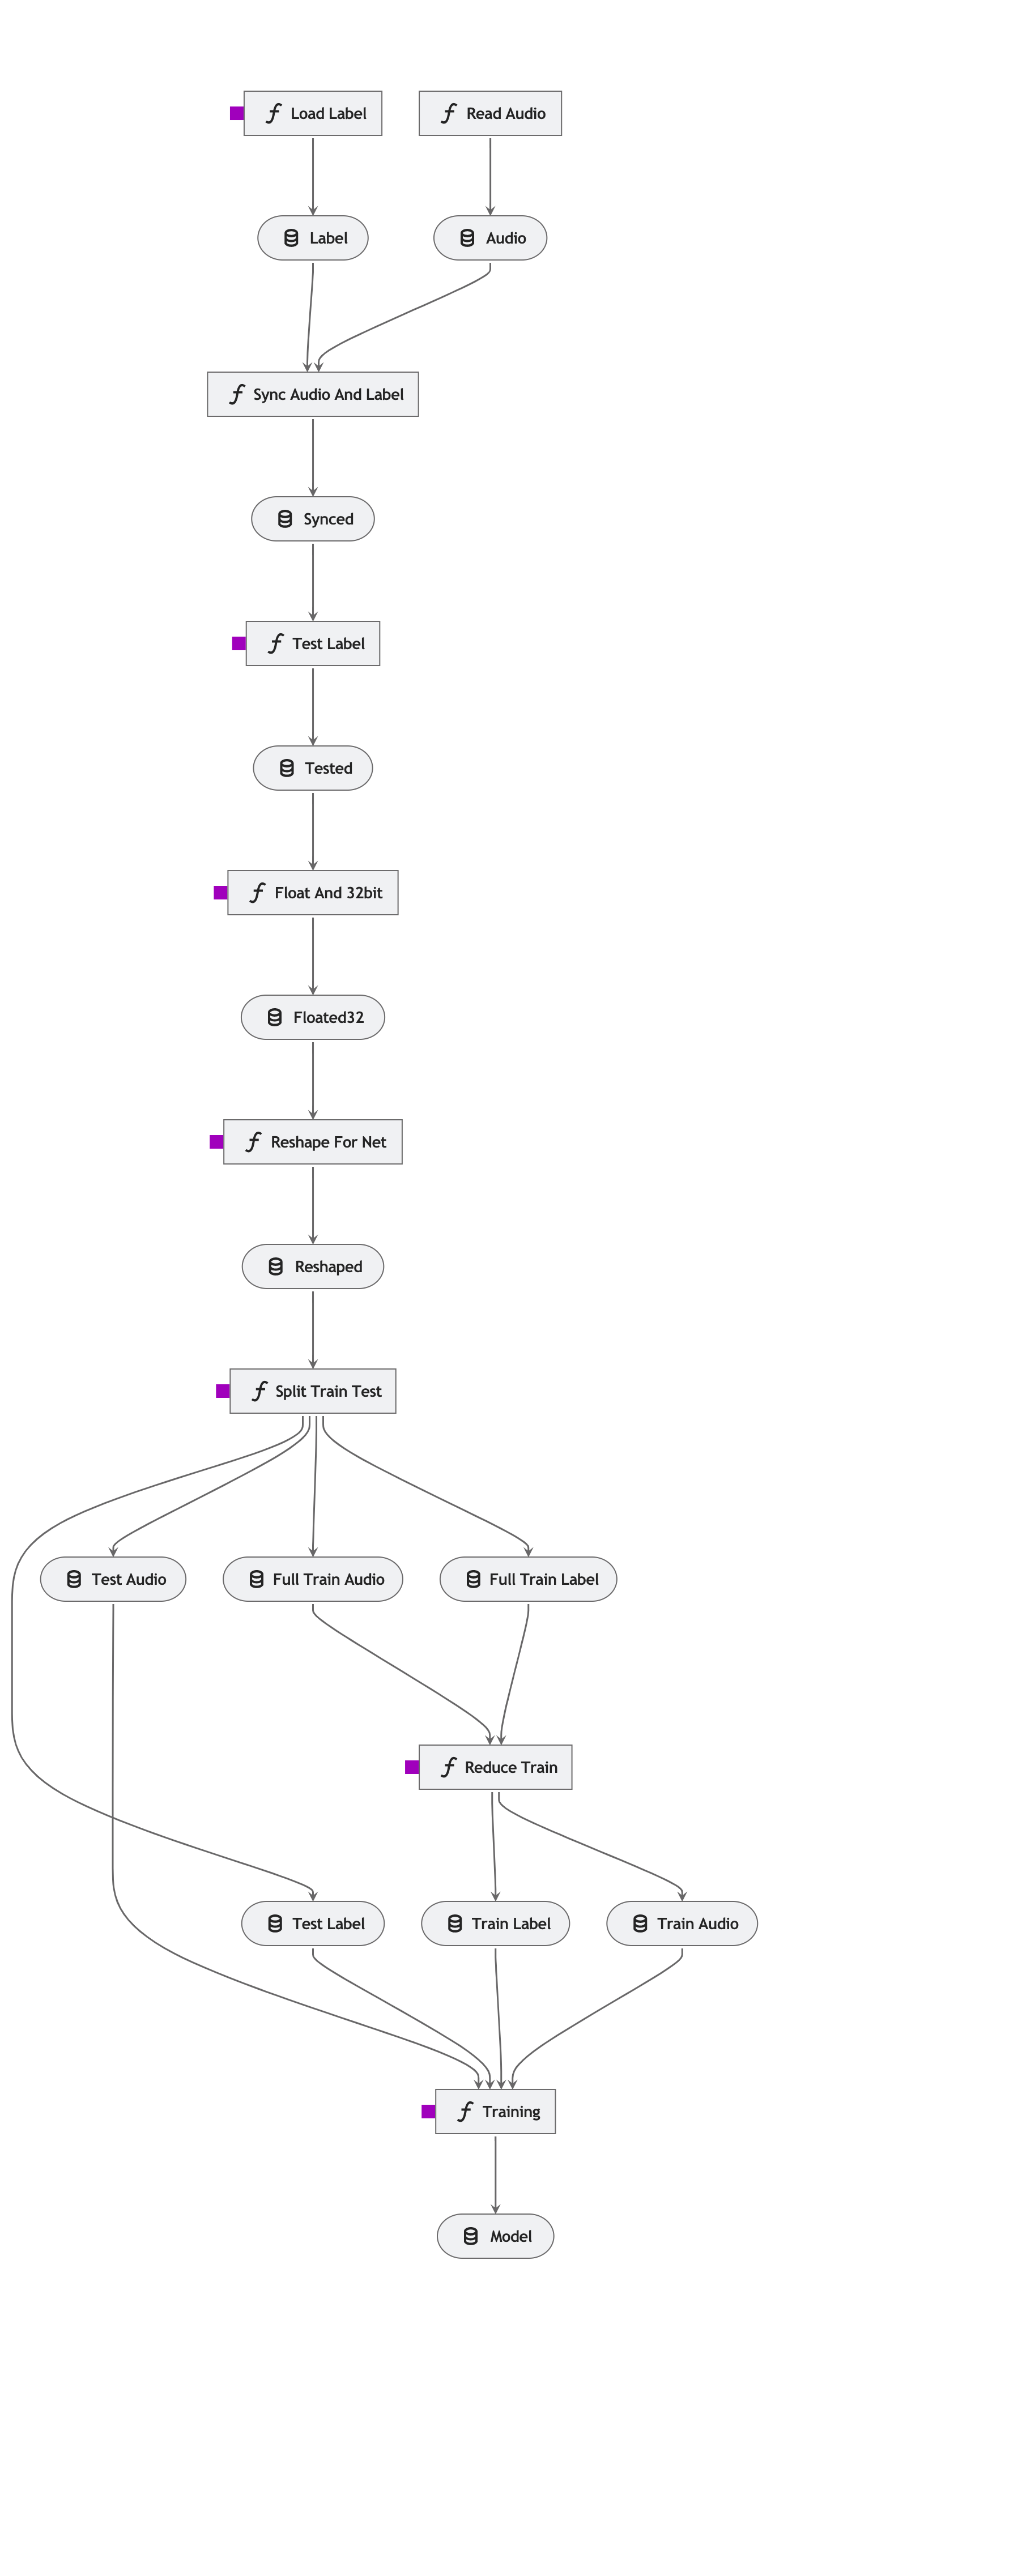

In [425]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_train_pipeline.png') 

##### Inference pipeline

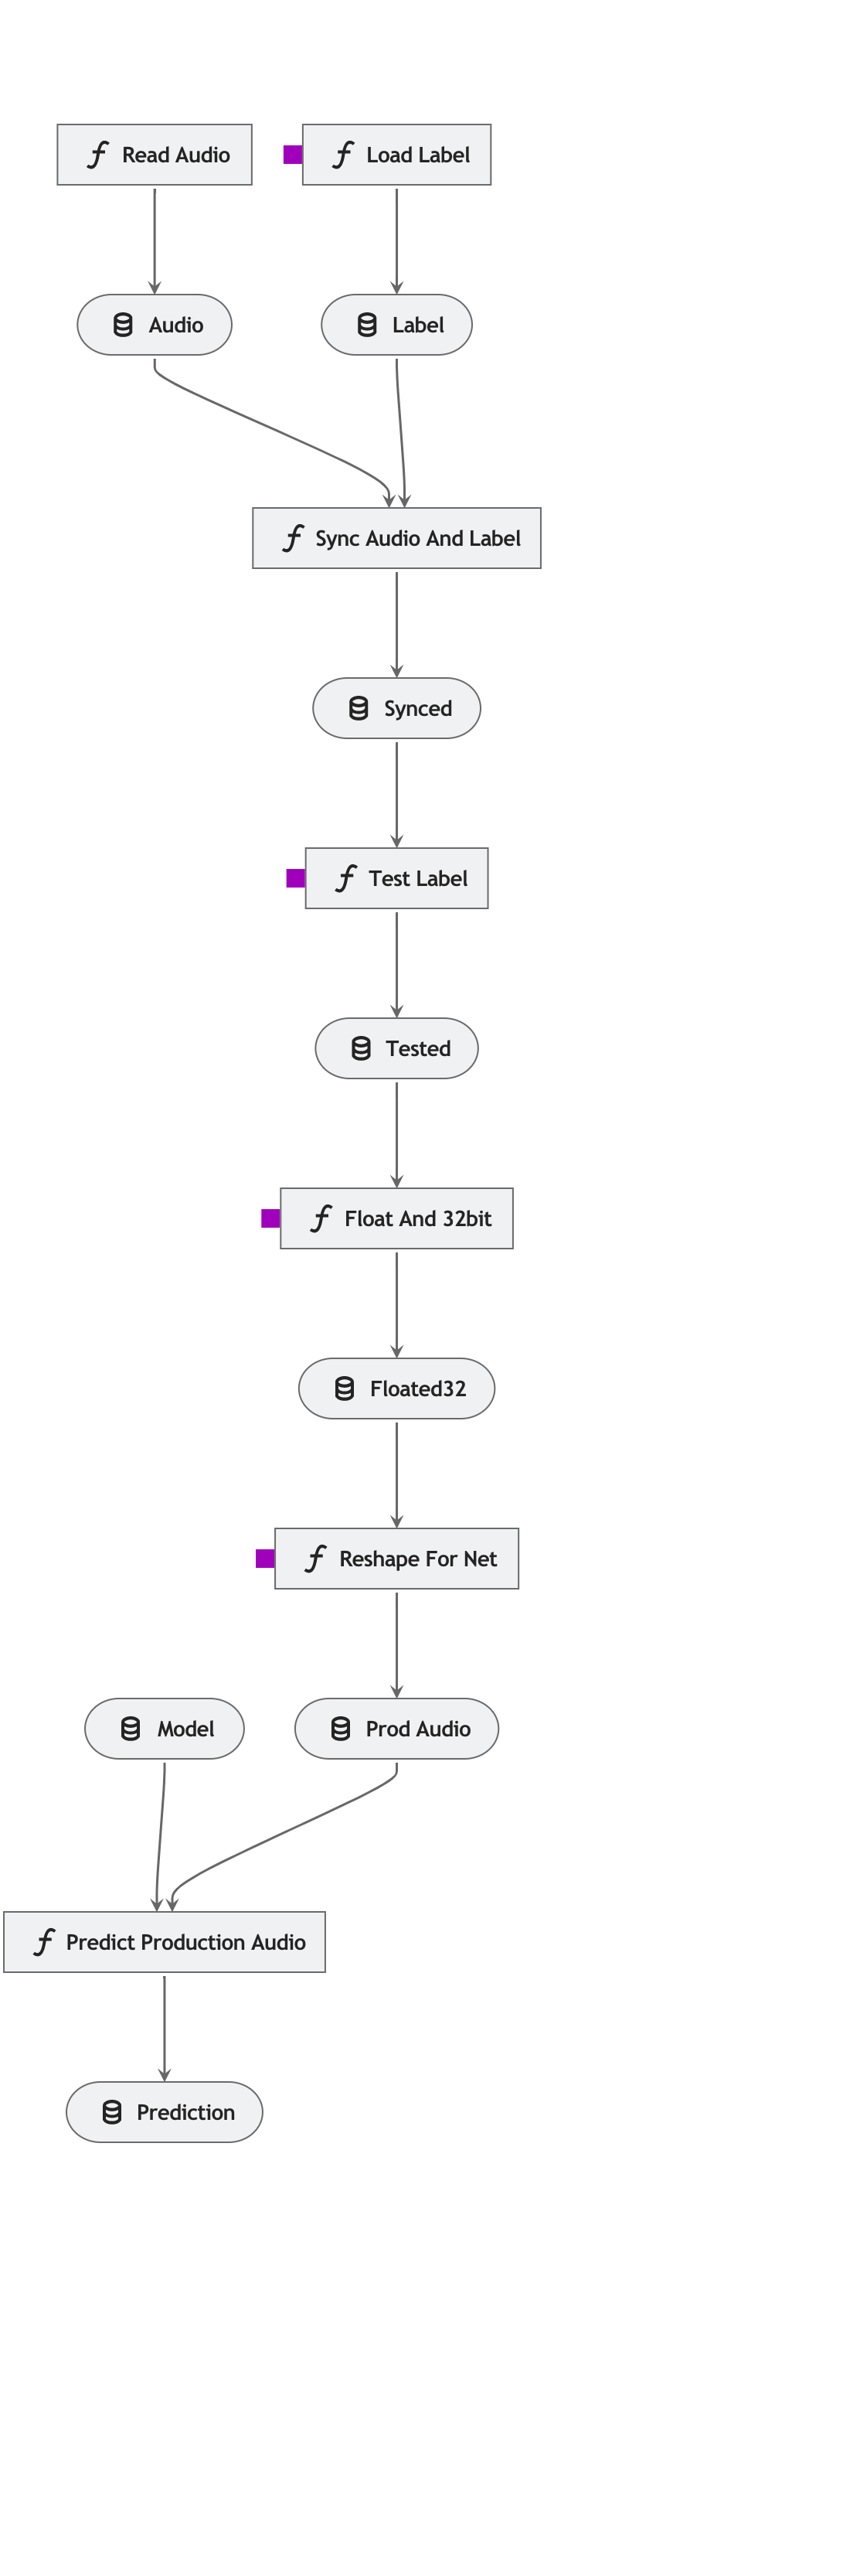

In [426]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/kedro_inference_pipeline.png') 

#### Neural network architecture

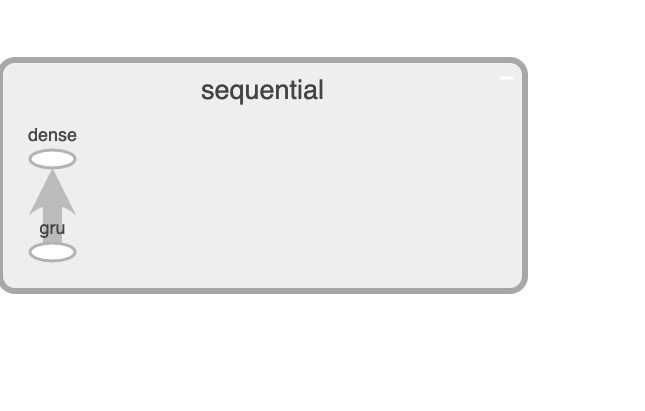

In [394]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/tb_conceptual_graph.png') 

##### Input

##### GRU layer

##### Dense layer

#### Batch inference

## Experiments

### Experimental setup

## Results

### Several speakers

Listening to a sample of the audio files revealed that a variety of speakers

- Humans
    - men
    - women
- Synthetic
    - men
    - women

I also characterised speeches by their variety of amplitudes and pace
- Normal vs fast pace  
- Loud vs, low volume

### Speech signal description

We show below the best typical example of an audio signal (top panel). and its associated speech labels "1" for speech and "0" for no speech (bottom panel).

All audio signals were 32 bits float single channel time series. We run a few sanity checks:

In [263]:
# load all data
data_path = "data/01_raw/vad_data/"
audio_files = glob.glob(f"{data_path}*.wav")
audio_files.sort()
label_files = glob.glob(f"{data_path}*.json")
label_files.sort()

In [264]:
# run sanity test on file-label name mapping and sorting
correct_mapping = []
for aud, lbl  in zip(audio_files, label_files):
    correct_mapping.append(os.path.splitext(aud)[0] == os.path.splitext(lbl)[0])
print(f"- the {sum(correct_mapping)} label files were correctly mapped with the {len(audio_files)} audio files")

- the 957 label files were correctly mapped with the 957 audio files


Speaker information:

In [265]:
# get speaker info
file_speaker = [os.path.basename(file).split("-")[0] for file in audio_files]
speaker_set = np.unique(file_speakers)
print("- Number:", len(speaker_set), "speakers")
print("- Speakers'ID:", speaker_set)

- Number: 34 speakers
- Speakers'ID: ['103' '1034' '1040' '1069' '1081' '1088' '1098' '1116' '118' '1183'
 '1235' '1246' '125' '1263' '1334' '1355' '1363' '1447' '1455' '150'
 '1502' '1553' '1578' '1594' '1624' '163' '1723' '1737' '1743' '1841'
 '1867' '1898' '19' '1926']


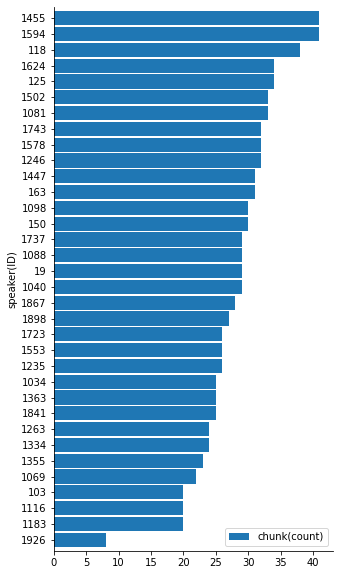

In [266]:
# get number of chunks per speaker
speaker, nb_chunks = zip(*Counter(file_speaker).items())
counts = pd.DataFrame(data=(speaker, nb_chunks), index=["speaker(ID)", "chunk(count)"]).T
counts.sort_values(by="chunk(count)").plot.barh(x="speaker(ID)", figsize=(5, 10), width=0.9);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [267]:
# define a few useful functions
def read_X(audio_path):
    sample_rate, data = scipy.io.wavfile.read(
        audio_path
    )
    sample_size = len(data)
    time_unit = 1 / sample_rate
    duration_in_sec = time_unit * len(data)
    timestamp = np.arange(0, len(data), 1) * time_unit
    return {
        "audio": {
            "data": data.reshape(sample_size, 1),
            "metadata": {
                "sample_rate": sample_rate,
                "sample_size": sample_size,
                "time_unit": time_unit,
                "duration_in_sec": duration_in_sec,
                "timestamp": timestamp,
            },
        }
    }
    
def load_Y(label_path):
    return pd.read_json(label_path)    

def sync_audio_and_labels(audio, label):

    # get data
    data = audio["audio"]["data"]
    time_unit = audio["audio"]["metadata"]["time_unit"]
    sample_size = audio["audio"]["metadata"]["sample_size"]

    # create timestamps
    audio["audio"]["metadata"]["timestamp"] = np.arange(0, len(data), 1) * time_unit

    # case label exists
    # synchronize labels with audio
    synced_label = np.zeros((sample_size, 1))
    array = label.values
    for ix in range(array.shape[0]):
        interval = array[ix][0]
        speech_start = interval["start_time"]
        speech_end = interval["end_time"]
        span = np.where(
            np.logical_and(
                audio["audio"]["metadata"]["timestamp"] >= speech_start,
                audio["audio"]["metadata"]["timestamp"] <= speech_end,
            )
        )
        synced_label[span] = 1
    audio["label"] = synced_label
    return audio

def load_synced_audio_and_label(audio_path, label_path):
    audio = read_X(audio_path)
    label = load_Y(label_path)
    return sync_audio_and_labels(audio, label)
    
def plot_labelled_audio(timestamp, audio, labels, n_sample):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,5))
    ax1.plot(timestamp, audio[:n_sample], "r-")

    # plot label
    ax2.plot(timestamp, labels[:n_sample], "b-")
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    
    return f, ax1, ax2

We show below a few interesting example chunks for 7 different speakers (numbered panels).
- All visualized audio were very well labelled (see supplementary).

SPEAKER 19 - PANEL 0
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


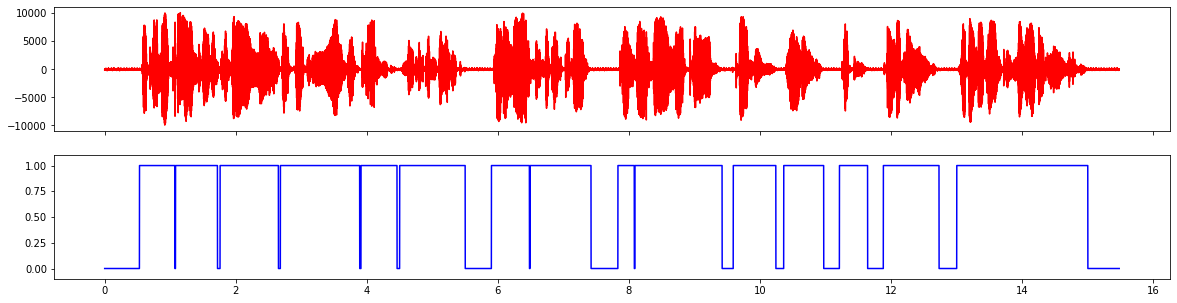

SPEAKER 1553 - PANEL 1
  data/01_raw/vad_data/1553-140048-0009.wav
  data/01_raw/vad_data/1553-140048-0009.json


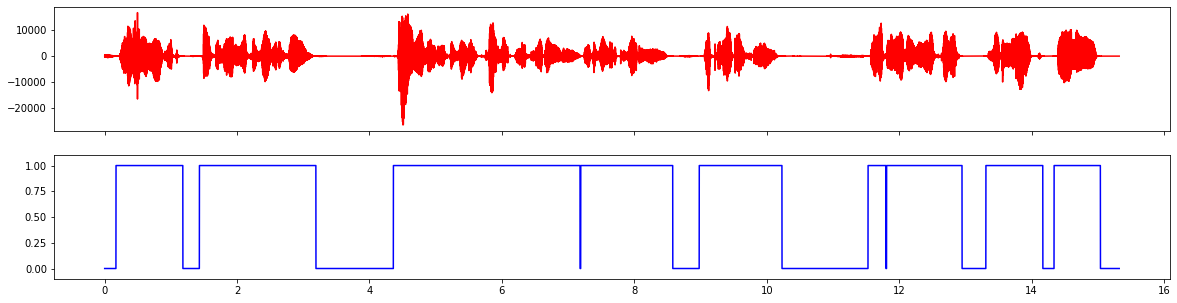

SPEAKER 103 - PANEL 2
  data/01_raw/vad_data/103-1241-0027.wav
  data/01_raw/vad_data/103-1241-0027.json


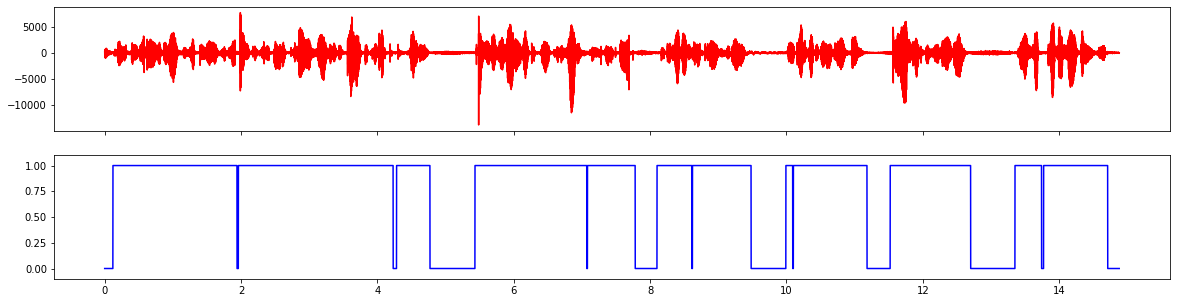

1.88 sec


In [397]:
# show an example per speaker
exple_pos = [920, 605, 17]

# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " , audio_files[exple])
    print(" " , label_files[exple])    
    audio = load_synced_audio_and_label(audio_files[exple], label_files[exple])
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )
if VERBOSE: 
    print(np.round(time.time()-tic,2), "sec")

We validated that all audio files were associated with a .json label file.


In [269]:
# data quality check
print("- audio file sample size:", len(audio_files))
print("- label file sample size:", len(label_files))

- audio file sample size: 957
- label file sample size: 957


The entire sample could be quickly loaded:

In [270]:
# loading
tic = time.time()
audio_data = [scipy.io.wavfile.read(audio) for audio in audio_files]
print("- loading duration:", np.round(time.time()-tic,2), "sec")

- loading duration: 2.89 sec


Sample size and sampling rate:

In [271]:
# get sample rate per audio
sample_rates = [audio for audio in np.array(audio_data)[:,0]]
sample_rate = np.unique(sample_rates)
print("Sample rate information:")
print("-", len(sample_rate), "sample rate(s)")
print("- rate:", np.unique(sample_rates)[0], "Hz")

Sample rate information:
- 1 sample rate(s)
- rate: 16000 Hz


We kept the signal at 16Khz which is enough to cover the frequency range of human speech according to the literature (Human voice b/w `85hz to 8khz` [REF], hearing b/w `20 hz to 20kh`[REF]).

In [272]:
# get sample size per audio
sample_sizes = [len(audio) for audio in np.array(audio_data)[:,1]]
print("Sample size information:")
print("-", len(np.unique(sample_sizes)), "sample size(s)")
print("- max:", max(sample_sizes), "samples (", max(sample_sizes)/sample_rate, "secs)")
print("- min:", min(sample_sizes), "samples (", min(sample_sizes)/sample_rate, "secs)")
print("- median:", np.median(sample_sizes), "samples (", np.median(sample_sizes)/sample_rate, "secs)")

Sample size information:
- 711 sample size(s)
- max: 275280 samples ( [17.205] secs)
- min: 22560 samples ( [1.41] secs)
- median: 222080.0 samples ( [13.88] secs)


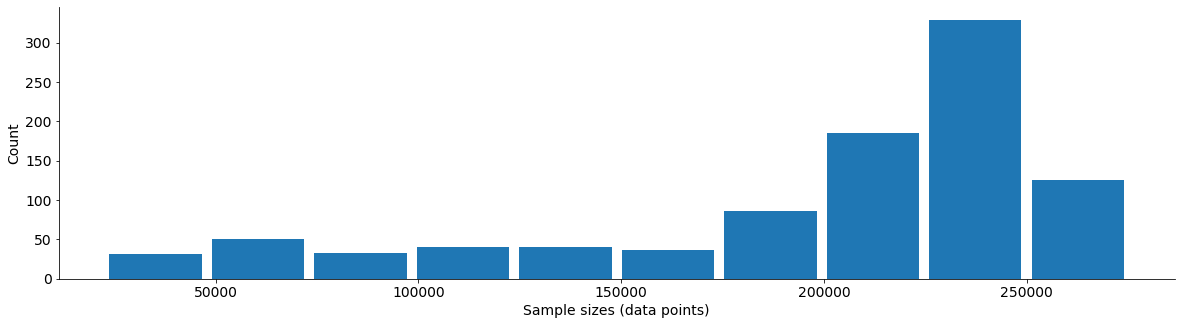

In [273]:
# sample size distribution
fig = plt.figure(figsize=(20,5))
plt.hist(sample_sizes, rwidth=0.9);
plt.xlabel("Sample sizes (data points)", fontsize=14);
plt.ylabel("Count", fontsize=14);
plt.xticks(fontsize=14); 
plt.yticks(fontsize=14);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

**Signal amplitudes**: the true decibel amplitude of the audio will depend on each speaker's microphone characteristics, the speaker's distance to its microphone, the speaker's volume configuration. Having no acces to these information we did not derive the true decibel amplitude (dB) from the raw audio signal amplitude or compared absolute amplitudes between speakers. Rather we compared the signals' signal-to-noise ratio (SNR).

### Speech signals are nearly pure

[TODO]: calculate the distribution of SNRs.
1. Estimate noise in frequency domain and decompose audio signal into signal and noise components.
2. Calculate the root-mean square level of the noise without speech and the speech without noise
3. Use to calculate SNR

In [274]:
# define some useful functions
def get_signal(audio_path, label_path):
    pass
def get_noice(audio_path, label_path):
    pass
def get_snr(audio_path, label_path):
    synced = load_synced_audio_and_label(audio_path, label_path)
    audio = synced["audio"]["data"]
    label = synced["label"]
    S_rms = audio[label==1]
    N_rms = label[label==0]
    return 20*np.log10(S_rms / N_rms)

In [276]:
# get snr
# get_snr(audio_files[0], label_files[0])

### A simple RNN show good performances

We first trained the model on a small chunk of one speaker data (2.8 secs) and tested it on all other speakers' data. We show below the distribution of the best model's False rejection rates over speakers. 

In [377]:
from kedro.pipeline import Pipeline, node
from vad.pipelines.data_eng.nodes import Etl, DataEng

def run_data_eng(**kwargs):
    return Pipeline(
        [
            node(
                func=Etl.test_on_label,
                inputs=["synced", "params:TEST"],
                outputs="tested",
                name="test_label",
            ),
            node(
                func=DataEng.set_resolution,
                inputs=["tested", "params:DATA_ENG"],
                outputs="floated32",
                name="float_and_32bit",
            ),
            node(
                func=DataEng.reshape_input_for_net,
                inputs=["floated32", "params:DATA_ENG"],
                outputs="prod_audio",
                name="reshape_for_net",
            ),
        ]
    )

We display below the sequential steps realised by our inference pipeline and the False rejection rates for all audio signals in the database.

In [ ]:
FRRs = []

for audio, label in zip(audio_files[:2], label_files[:2]):
    tic = time.time()
    
    # track experiments
    mlflow.set_experiment("/explore")
    mlflow.end_run()
    with mlflow.start_run():

        # set inference pipeline parameters
        DATA_ENG = MemoryDataSet(data={
                     "LABEL": True,
                     "REDUCE_TRAIN": False,
                     "TIMESTEPS": 1,
                     "N_CLASSES": 2,
                     "RESOLUTION": "float16",
                 })
        TEST = MemoryDataSet(data={
              "SHUFFLE_LABEL": False, # must be false: random audio-label mapping
              "ALL_SPEECH": False, # must be false: random audio-label mapping
              "NO_SPEECH": False, # must be false: random audio-label mapping  
             })

        # load and sync data to predict
        synced = load_synced_audio_and_label(audio, label)
        synced = MemoryDataSet(data=synced)

        # load trained model
        model = TensorFlowModelDataset(filepath="data/06_models/model")

        # configure pipeline dataset and parameters inputs
        io = DataCatalog(data_sets={'audio': [1, 2, 3], 
                                    'home': [1, 2, 3], 
                                    'params:DATA_ENG': DATA_ENG,
                                    'params:TEST': TEST, 
                                    "model": model,
                                    "synced": synced
                                   }
                        )

        # build pipeline
        pipeline = Pipeline(
            [
                run_data_eng(), 
                inference.run(), 
                evaluate.run()
            ]
        )

        # run pipeline
        output = SequentialRunner().run(pipeline, catalog=io)
        
        # record FRR
        FRR = output["metrics"]["false_rejection_rate"].item()
        FRRs.append(FRR)
        print(np.round(time.time()-tic,2), "secs")

# plot histogram
pd.DataFrame(FRRs).hist()

2021-09-01 10:35:16,354 - kedro.io.data_catalog - INFO - Loading data from `synced` (MemoryDataSet)...
2021-09-01 10:35:16,368 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-01 10:35:16,380 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-01 10:35:16,383 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-01 10:35:16,387 - kedro.runner.sequential_runner - INFO - Completed 1 out of 8 tasks
2021-09-01 10:35:16,389 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-01 10:35:16,392 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-01 10:35:16,401 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-01 10:35:16,406 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09

## Conclusion

## Discussion

## References

## Supplementary results

## Each speaker first audio signal

In [ ]:
# show an example per speaker
_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)
    
# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " ,audio_files[exple])
    print(" " ,label_files[exple])    
    audio = read_X(audio_files[exple])
    label = load_Y(label_files[exple])
    synced = sync_audio_and_labels(audio, label)
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )
if VERBOSE: 
    print(np.round(time.time()-tic,2), "sec")